### In this notebook we will only consider the Unet model from scratch. We will test the model under dice loss function.

In [ ]:
# Import the libraies
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
import six
from collections import namedtuple
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.layers import concatenate,BatchNormalization, UpSampling2D, SeparableConv2D, add, Activation, Conv2DTranspose
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

from imgaug import augmenters as iaa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Paths to the G-Drive

In [ ]:
model_path = '/content/drive/MyDrive/P08/models'
checkpoint_path='/content/drive/MyDrive/P08/checkpoints'
train_input_dir = '/content/drive/MyDrive/P08/train/images'
train_mask_dir = '/content/drive/MyDrive/P08/train/masks30'
train_target_dir = '/content/drive/MyDrive/P08/train/masks'
val_input_dir = '/content/drive/MyDrive/P08/val/images'
val_mask_dir = '/content/drive/MyDrive/P08/val/masks30'
val_target_dir = '/content/drive/MyDrive/P08/val/masks'
test_input_dir = '/content/drive/MyDrive/P08/test/images'
test_mask_dir = '/content/drive/MyDrive/P08/test/masks30'
test_target_dir = '/content/drive/MyDrive/P08/test/masks'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of masks in 8 categories: ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of masks in 8 categories: ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of masks in 8 categories: ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2400  - Number of original masks:  2400  - Number of masks in 8 categories:  2400
/content/drive/MyDrive/P08/train/images/aachen_000000_000019.png

VAL -- Number of images:  575  - Number of original masks:  575  - Number of masks in 8 categories:  575
/content/drive/MyDrive/P08/val/images/stuttgart_000124_000019.png

TEST -- Number of images:  500  - Number of original masks:  500  - Number of masks in 8 categories:  500
/content/drive/MyDrive/P08/test/images/frankfurt_000000_000294.png


#### Create a dataframe to compare the models

In [ ]:
model_result=pd.DataFrame(columns=['model_name','epochs','training_time', 'eval_time','accuracy',
                                   'val_accuracy', 'mean_IoU','val_mean_IoU'])

#### We will utilise two loss functions dice and balanced cross entropy.

#### Dice Loss

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator / denominator

#### Hyperparameters for the model

Now we define the hyperparameters for the model.



In [ ]:
img_height, img_width = 128, 128
img_size = (img_height, img_width)
batch_size = 20
n_classes = 8
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mean_IoU = tf.keras.metrics.MeanIoU(num_classes=8, name='mean_IoU')
epochs = 10

In [ ]:
from collections import namedtuple

# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    
    # Get the mapping
    map_category = np.vectorize(cat_label.get)
    return map_category

#### Define the sequence generator

In [ ]:
class seg_gen(Sequence):
    """Create the data generator
    """

    # ==== Initialize the class ==== #
    def __init__(self, input_path, target_path, img_size, batch_size, 
                 labels, n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()


    # ==== Set the number of batches per epoch ==== #
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))
    
    
    # ==== Call a method at the end of each epoch ==== #
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))
        
        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    # ==== Get batches of images & masks ==== #
    def __getitem__(self, index):
       # Genere batch_size numbers d'ID of row of DATA (batch_size=2, [0,1])
       currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    
       batch_x, batch_y = [], []
    
       # Iterate over indexes
       for i, rowId in enumerate(currentBatchIdsRow):
           # Load image, set target size, convert to array, normalize
           image = img_to_array(
               load_img(f'{self.input_path[i]}', 
                        target_size=img_size))/255.
           batch_x.append(image)

           # Load original mask, set target size and convert to array
           mask8 = img_to_array(
               load_img(f'{self.target_path[i]}', color_mode = "grayscale", 
                        target_size=img_size))
           
           # Load 8 main categories
           mask = to_categorical(mask8, self.n_classes)                   
           batch_y.append(mask)
     
       return np.array(batch_x), np.array(batch_y)

In [ ]:
# Create the data generator
train_gen = seg_gen(train_input_path, train_target_path, img_size, 
                         batch_size, labels, n_classes, shuffle=False)
val_gen = seg_gen(val_input_path, val_target_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)
test_gen = seg_gen(test_input_path, test_target_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)

In [ ]:
len(train_gen), len(val_gen), len(test_gen)

(120, 28, 25)

Let see some images from the train and the test generator

In [ ]:
train_image_batch, train_mask_batch =train_gen.__getitem__(0)
len(train_image_batch), len(train_mask_batch)

(20, 20)

In [ ]:
print(train_image_batch.shape)
print(train_mask_batch.shape)

(20, 128, 128, 3)
(20, 128, 128, 8)


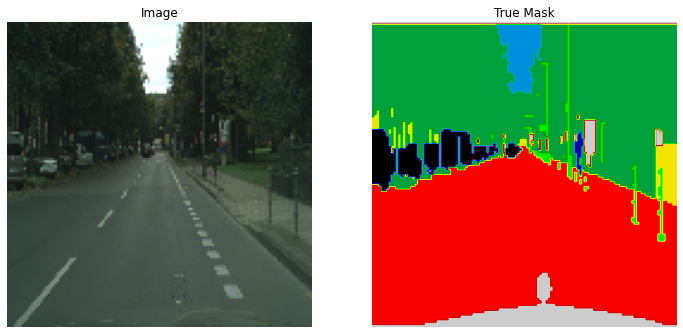

In [ ]:
import random
train_img_number = random.randint(0, len(train_image_batch)-1)
train_img = train_image_batch[train_img_number]
mask_true=train_mask_batch[train_img_number]
mask_true = np.argmax(mask_true, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Image')
plt.imshow(train_img)
plt.axis('off')
plt.subplot(122)
plt.title('True Mask')
plt.imshow(mask_true, cmap='nipy_spectral_r')
plt.axis('off')
plt.show()

In [ ]:
# Test generator
test_image_batch, test_mask_batch =test_gen.__getitem__(0)
len(test_image_batch), len(test_mask_batch)

(20, 20)

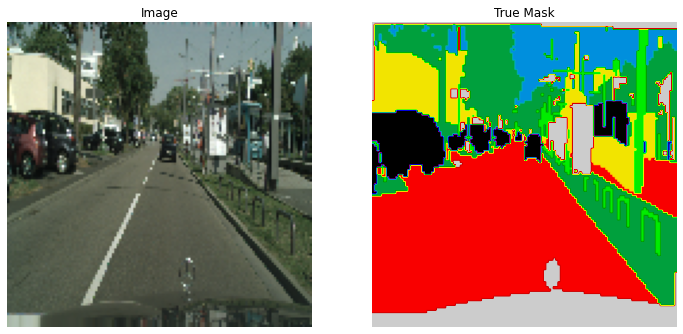

In [ ]:
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
mask_true=test_mask_batch[test_img_number]
mask_true = np.argmax(mask_true, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Image')
plt.imshow(test_img)
plt.axis('off')
plt.subplot(122)
plt.title('True Mask')
plt.imshow(mask_true, cmap='nipy_spectral_r')
plt.axis('off')
plt.show()

### Create a simple Unet model

Convolution block with 2 conv layers and batch normalization for each layer

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

Encoder block: Conv block followed by maxpooling. Returns both convolution and maxpooling outputs. The conv output can be used for concatenation (skip connections) with decoder.

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

Decoder Block: Skip features gets input from encoder for concatenation

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(img_size, n_classes):
    inputs = Input(shape=img_size + (3,))

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)


    outputs = Conv2D(n_classes, 1, padding="same", activation='softmax')(d4)  

    model = Model(inputs, outputs)
    return model

In [ ]:
unet_model = build_unet(img_size, n_classes=n_classes)

### Now we use this model using the dice loss.

In [ ]:
model_name= 'unet_dice'

model = unet_model  
model.compile(optimizer=optimizer, 
              loss=dice_loss,
              metrics=[mean_IoU, 'accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

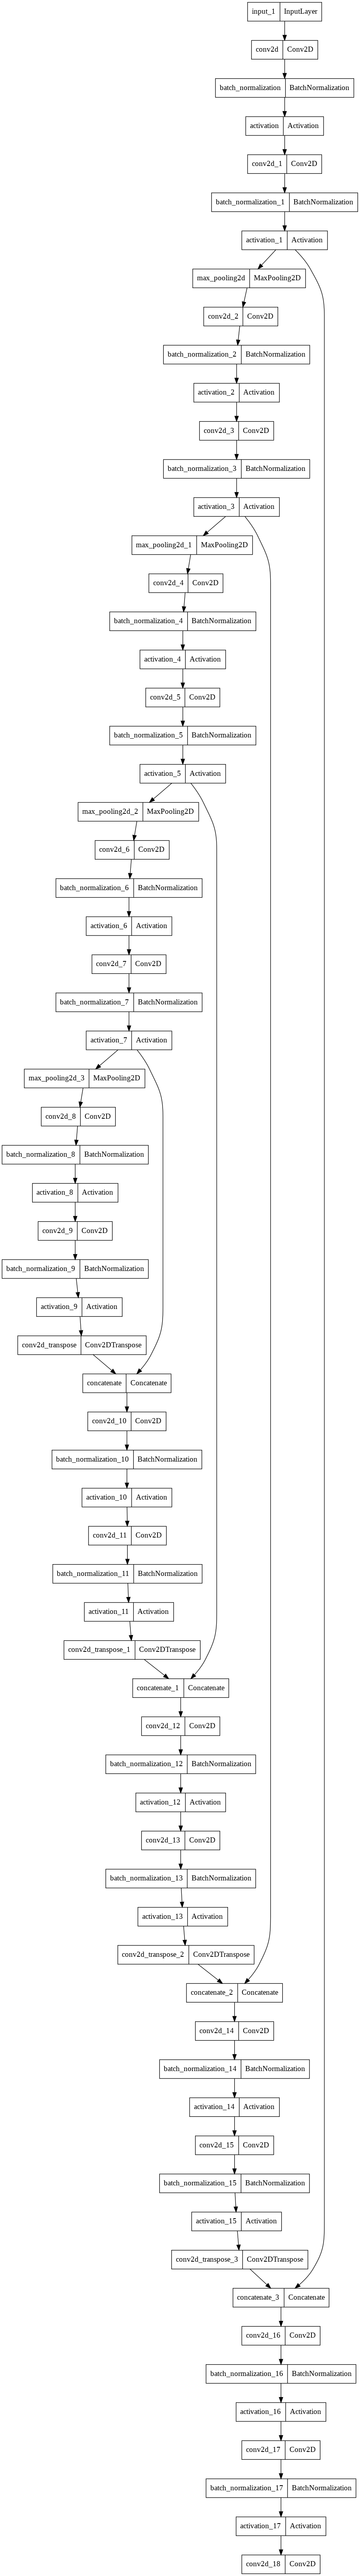

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 44.3 MB/s 


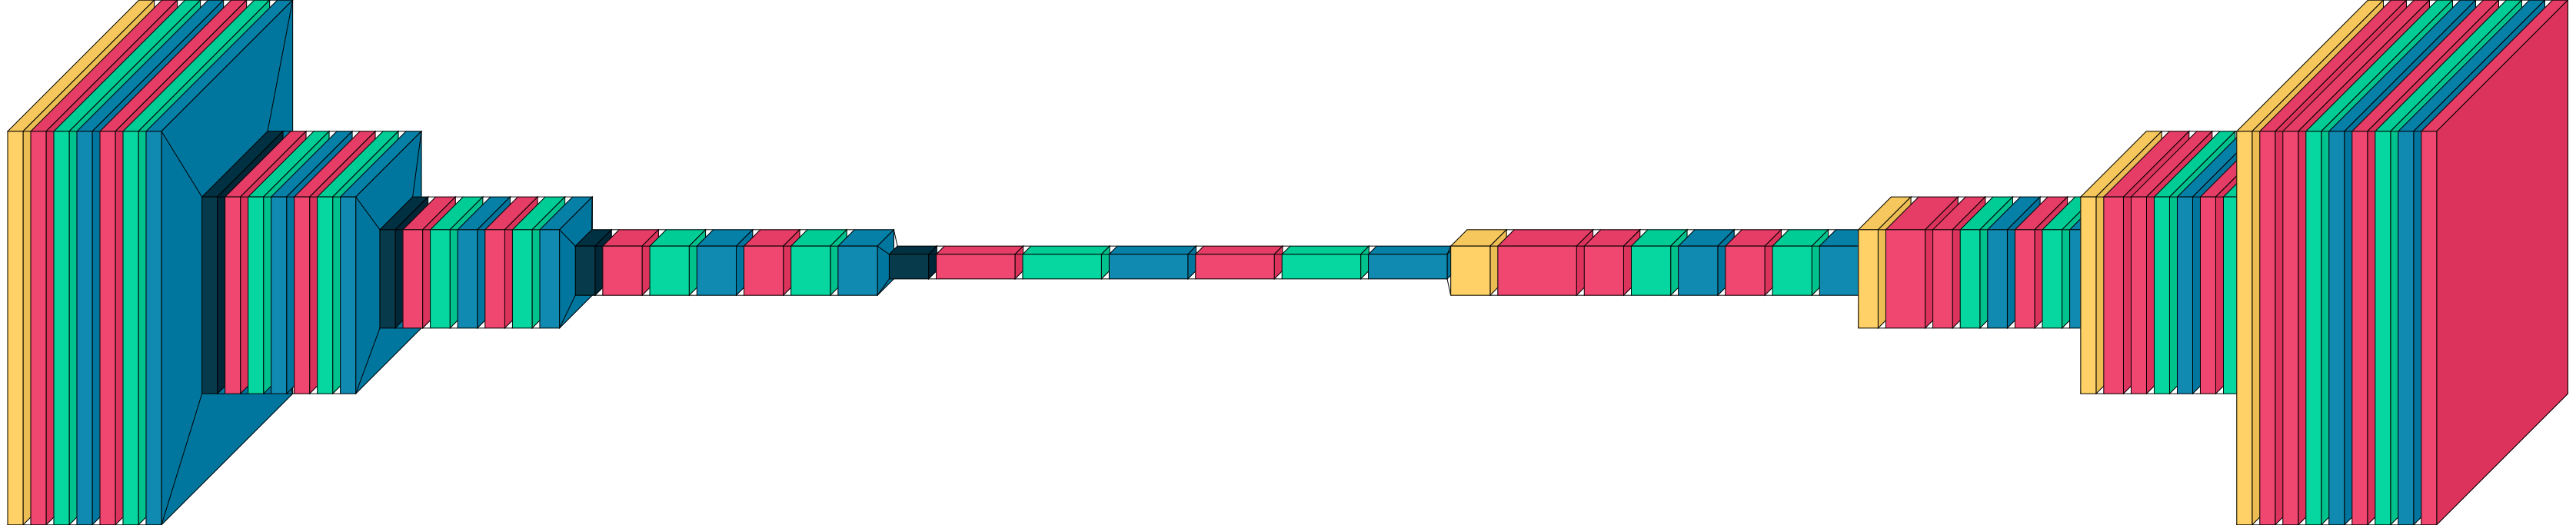

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

history=model.fit(train_gen, 
                    epochs=epochs,
                    validation_data = val_gen,
                    callbacks=callbacks)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

Training for unet_dice
Epoch 1/10
120/120 [==============================] - 356s 3s/step - loss: 0.7353 - mean_IoU: 0.4375 - accuracy: 0.8510 - val_loss: 0.8022 - val_mean_IoU: 0.4375 - val_accuracy: 0.0638
Epoch 2/10
120/120 [==============================] - 290s 2s/step - loss: 0.7263 - mean_IoU: 0.4375 - accuracy: 0.9383 - val_loss: 0.7752 - val_mean_IoU: 0.4375 - val_accuracy: 0.3823
Epoch 3/10
120/120 [==============================] - 320s 3s/step - loss: 0.7247 - mean_IoU: 0.4376 - accuracy: 0.9540 - val_loss: 0.7720 - val_mean_IoU: 0.4375 - val_accuracy: 0.4184
Epoch 4/10
120/120 [==============================] - 285s 2s/step - loss: 0.7250 - mean_IoU: 0.4380 - accuracy: 0.9511 - val_loss: 0.7764 - val_mean_IoU: 0.5289 - val_accuracy: 0.3673
Epoch 5/10
120/120 [==============================] - 288s 2s/step - loss: 0.7237 - mean_IoU: 0.4388 - accuracy: 0.9656 - val_loss: 0.7441 - val_mean_IoU: 0.4375 - val_accuracy: 0.7382
Epoch 6/10
120/120 [==============================] 

In [ ]:
# Function to plot the learning curve
def plot_graphs(history):
    plt.figure(figsize=(20,4))
    
    plt.subplot(131)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'])
    
    plt.subplot(132)
    plt.plot(history.history['mean_IoU'])
    plt.plot(history.history['val_mean_IoU'])
    plt.xlabel('Epochs')
    plt.ylabel('mean_IoU')
    plt.legend(['mean_IoU', 'val_mean_IoU'])
    plt.show()

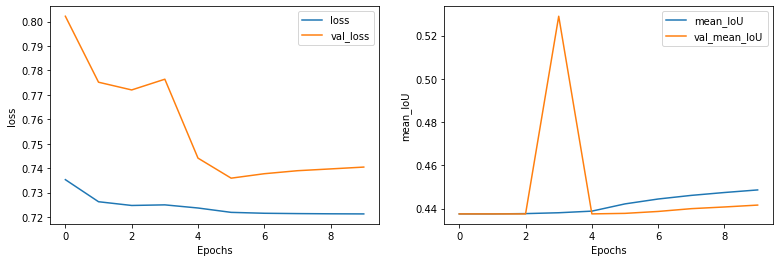

In [ ]:
 plot_graphs(history)

In [ ]:
# Evaluate the model
start_eval = time()
pred = model.predict(test_gen)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

25/25 [==============================] - 57s 2s/step
Evaluation time : 59.82289934158325


In [ ]:
type(test_gen.__getitem__(0))

tuple

In [ ]:
test_image_batch, test_mask_batch =test_gen.__getitem__(0)
len(test_image_batch), len(test_mask_batch)

(20, 20)

1/1 [==============================] - 0s 355ms/step


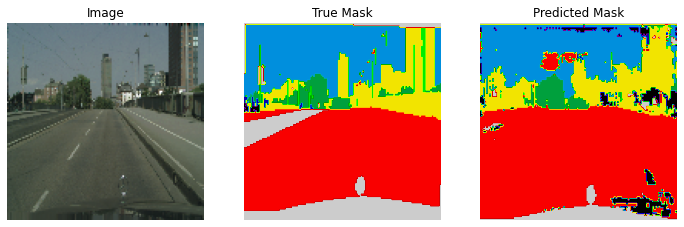

In [ ]:
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
mask_true=test_mask_batch[test_img_number]
mask_true = np.argmax(mask_true, axis=2)
prediction = model.predict(test_image_batch)
pred_batch=np.argmax(prediction, axis=-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img)
plt.axis('off')
plt.subplot(232)
plt.title('True Mask')
plt.imshow(mask_true, cmap='nipy_spectral_r')
plt.axis('off')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(pred_batch[test_img_number], cmap='nipy_spectral_r')
plt.axis('off')
plt.show()

In [ ]:
# Performance of the model
model_result = model_result.append(
        pd.Series(data={'model_name': model_name,
                        'epochs':epochs,
                        'training_time': time() - start,
                        'eval_time': time() - start_eval,
                        'accuracy': max(history.history['accuracy']),
                        'val_accuracy': max(history.history['val_accuracy']),
                        'mean_IoU' : max(history.history['mean_IoU']),
                        'val_mean_IoU' : max(history.history['val_mean_IoU'])}),
                        ignore_index=True)

In [ ]:
model_result

,model_name,epochs,training_time,eval_time,accuracy,val_accuracy,mean_IoU,val_mean_IoU
0,unet_dice,10,3044.12139,64.660357,0.991141,0.828564,0.448594,0.528934
